# title: "Predicting the value of y with x in a non parametric relationship"
author: "Anurag Jha" date: "May 4, 2020"

In [1]:
start_time <- Sys.time()

options(warn=-1)
options(msg=-1)

First the dataset was loaded from the csv file and a graph was plotted to check the trend.

In [2]:
dataset<- read.csv("C:/Users/anuragsuperman/Desktop/finalexam/final.csv")
head(dataset)


,x,y
,<dbl>,<dbl>
1,1.145850418,2.12275881
2,0.005434824,0.05681787
3,0.277618504,1.17830369
4,1.008530180,2.08646156
5,1.170458130,2.14543025
6,-0.998999052,-2.12895628


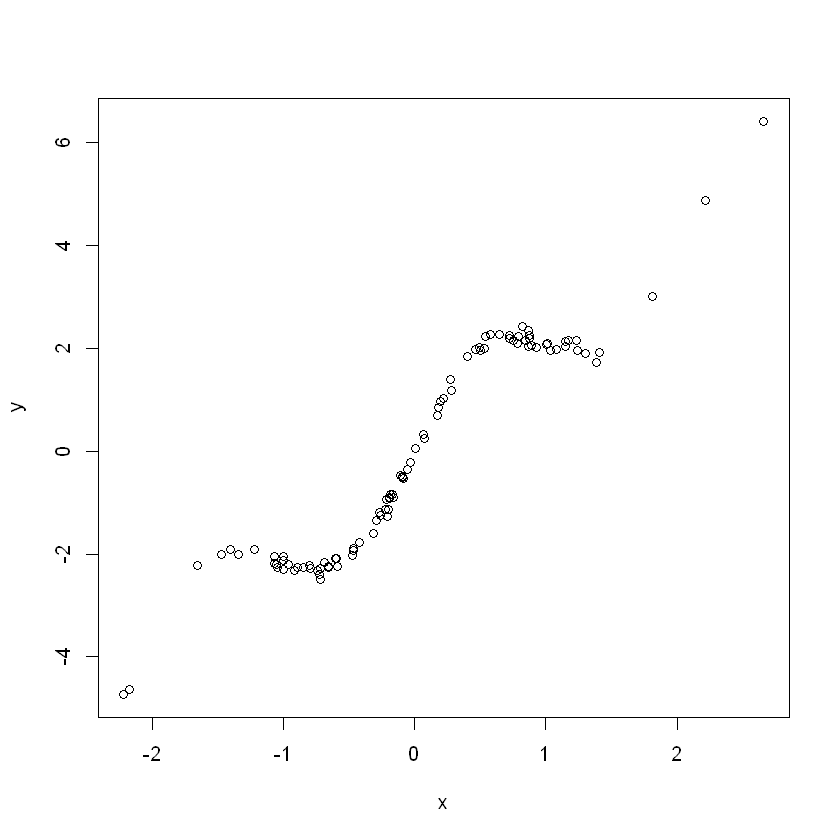

In [3]:
x<- c(dataset$x)
y<- c(dataset$y)
plot(x,y)

The plot shows non parametric relation between x and y.

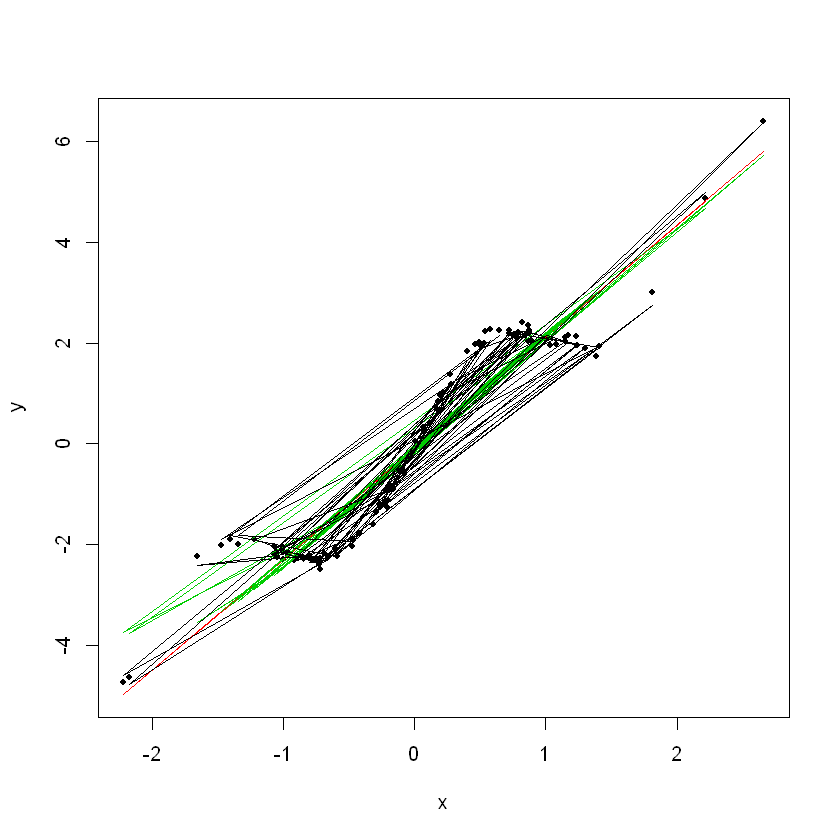

In [4]:
g1 <- lm(y ~ poly(x,1)) 
g4 <- lm(y ~ poly(x,4))
g12 <- lm(y ~ poly(x,8))
matplot(x,cbind(y, g1$fit, g4$fit,g12$fit),type="plll",  ylab="y",lty=c(1,1,1), pch=20, col=c(1,2,3))

Models with high R squared values however did not fit the graphs right and looks more of an overfitting issue. Thus we will try other methods to predict y with x variable.
The method Regressiogram is used to predict the best fit in this method.

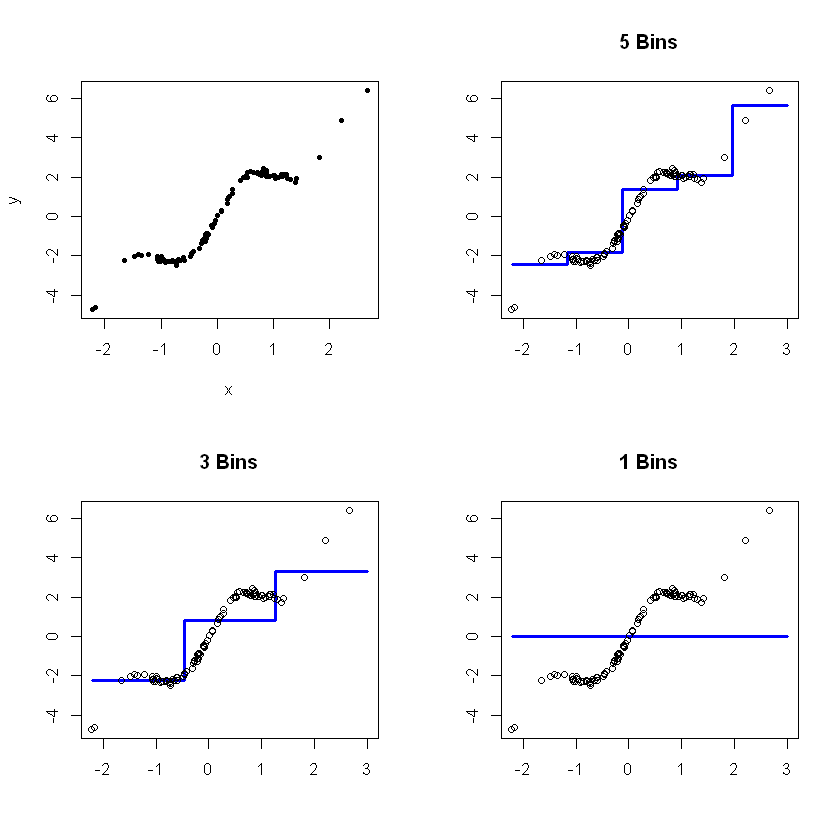

In [5]:
#Regressiogram
regressogram = function(x,y,left,right,k,plotit,xlab="",ylab="",sub=""){
                ### assumes the data are on the interval [left,right]
                n = length(x)
                B = seq(left,right,length=k+1)
                WhichBin = findInterval(x,B)
                N = tabulate(WhichBin)
                m.hat = rep(0,k)
                for(j in 1:k){
                if(N[j]>0)m.hat[j] = mean(y[WhichBin == j])
                }
                if(plotit==TRUE){
                a = min(c(y,m.hat))
                b = max(c(y,m.hat))
                plot(B,c(m.hat,m.hat[k]),lwd=3,type="s",
                xlab=xlab,ylab=ylab,ylim=c(a,b),col="blue",sub=sub,main=paste(k," Bins", sep=""))
                
                points(x,y)
                }
                return(list(bins=B,m.hat=m.hat))
                }
par(mfrow=c(2,2))

plot(x,y,pch=20)
out = regressogram(x,y,left=-2.2,right=3,k=5,plotit=TRUE)
out = regressogram(x,y,left=-2.2,right=3,k=3,plotit=TRUE)
out = regressogram(x,y,left=-2.2,right=3,k=1,plotit=TRUE)


For range of -2 to 3, we use different k values. These values give us under-fitting and overfitting results and we need just right results. Thus to choose from 1 to 5, we use leave one out cross validation (LOOCV) method and check the best fit for our model.

In [6]:
#Choose h or k by LOO#
n = length(x)
# n: sample size
h_seq = seq(from=1,to=5, by=1)
# smoothing bandwidths we are using
CV_err_h = rep(NA,length(h_seq))
for(j in 1:length(h_seq)){
h_using = h_seq[j]
CV_err = rep(NA, n)
for(i in 1:n){
X_val = x[i]
Y_val = y[i]
# validation set
X_tr = x[-i]
Y_tr = y[-i]
# training set
Y_val_predict = ksmooth(x=X_tr,y=Y_tr,kernel = "normal",bandwidth=h_using,
x.points = X_val)
CV_err[i] = (Y_val - Y_val_predict$y)^2
# we measure the error in terms of difference square
}
CV_err_h[j] = mean(CV_err)
}
CV_err_h

[1] 0.1830708 0.9371493 1.8215044 2.5531689 3.0709667

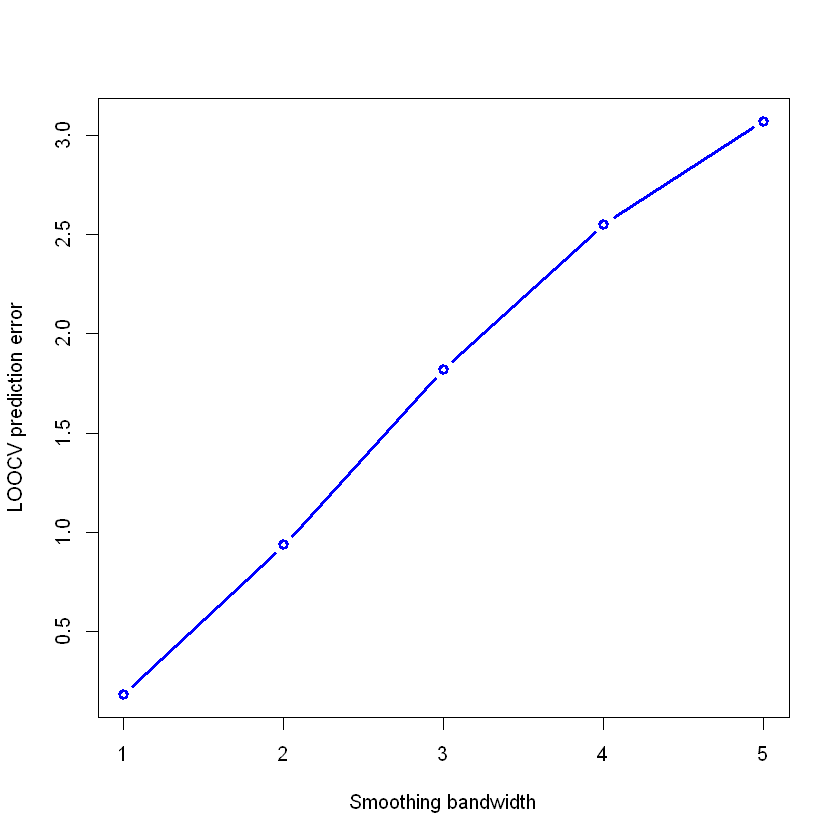

In [7]:
plot(x=h_seq, y=CV_err_h, type="b", lwd=3, col="blue",
xlab="Smoothing bandwidth", ylab="LOOCV prediction error")

In [8]:
h_seq[which(CV_err_h == min(CV_err_h))]

[1] 1

The best value of k is 1 with the least error of 0.183. But the graph clearly shows that we can get better results and smaller error rate (with k<1). We cross check the results with k-fold cross validation process to verify the results.

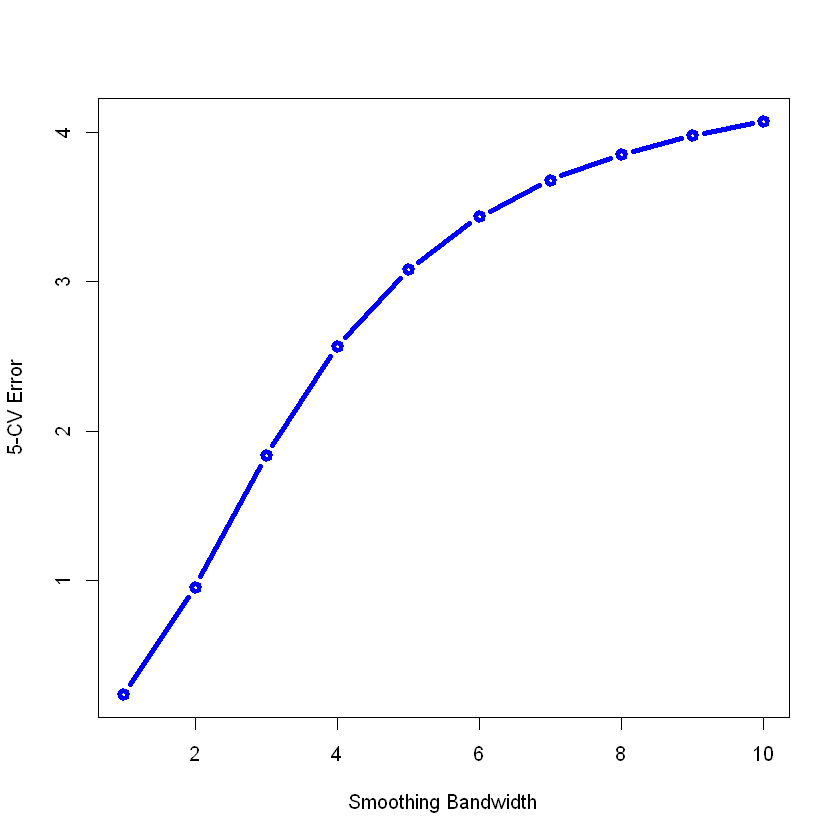

In [9]:
#5-fold Cross-validation#
#############5-fold Cross-validation############################################
set.seed(0)
n = length(x)
N_cv = 100
k = 5
cv_lab = sample(n,n,replace=F) %% k
## randomly split all the indices into k numbers
h_seq = seq(from=1,to=10, by=1)
CV_err_h = rep(0,length(h_seq))
for(i_tmp in 1:N_cv){
  CV_err_h_tmp = rep(0, length(h_seq))
  cv_lab = sample(n,n,replace=F) %% k
    for(i in 1:length(h_seq)){
    h0 = h_seq[i]
    CV_err =0
      for(i_cv in 1:k){
      w_val = which(cv_lab==(i_cv-1))
      X_tr = x[-w_val]
      Y_tr = y[-w_val]
      X_val = x[w_val]
      Y_val = y[w_val]
      kernel_reg = ksmooth(x = X_tr,y=Y_tr,kernel = "normal",bandwidth=h0,
      x.points=X_val)
      # WARNING! The ksmooth() function will order the x.points from
        # the smallest to the largest!
        CV_err = CV_err+mean((Y_val[order(X_val)]-kernel_reg$y)^2,na.rm=T)
        # na.rm = T: remove the case of 'NA'
        }
    CV_err_h_tmp[i] = CV_err/k
    }
  CV_err_h = CV_err_h+CV_err_h_tmp
  }
CV_err_h = CV_err_h/N_cv
plot(h_seq,CV_err_h, type="b", lwd=4, col="blue", xlab="Smoothing Bandwidth",
ylab="5-CV Error")

In [10]:
h_opt = h_seq[which(CV_err_h==min(CV_err_h))]
h_opt

[1] 1

The k- fold cross validation method with k=5 gave us the best value for the model as 1. The model is clearly an under fit and we will proceed with a better method for the prediction.
The Kernal Smoothing is more precise with prediction. The three values of h, chosen here are 0.1, 0.5, and 1. The three values have close prediction precision and thus we will choose the best value of h with the help of LOOCV and K-fold Cross Validation methods.

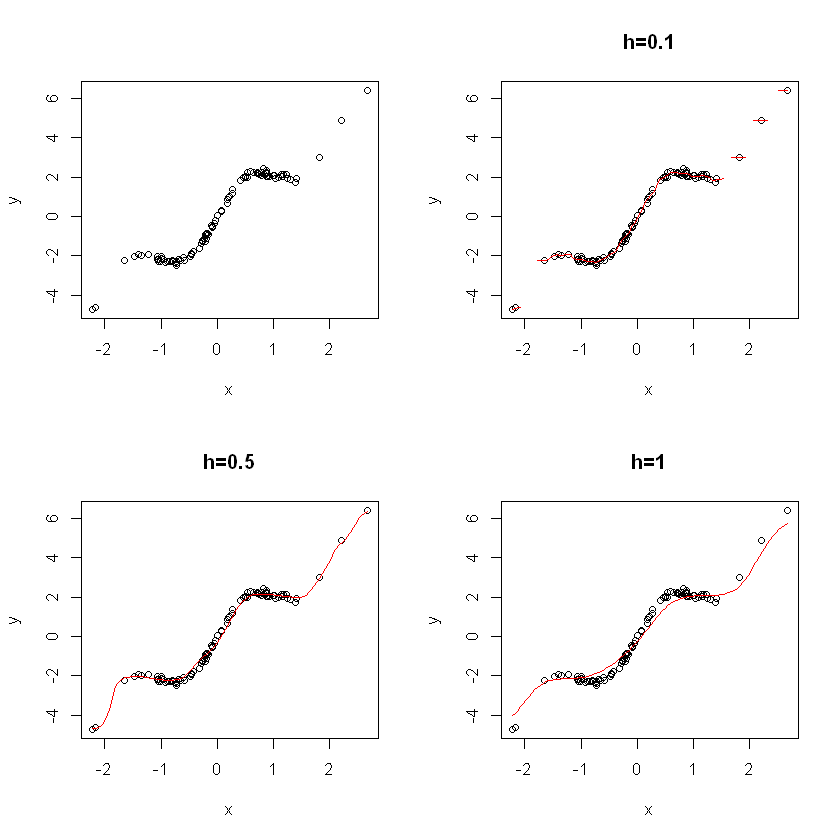

In [11]:
#Kernel Smoothing
par(mfrow=c(2,2))
plot(x,y) 
h<-0.1;     plot(x,y,main=paste("h=", h, sep="")); lines(ksmooth(x, y, "normal", bandwidth = h), col = 2)
h<-0.5;    plot(x,y,main=paste("h=", h, sep="")); lines(ksmooth(x, y, "normal", bandwidth = h), col = 2)        
h<-1;    plot(x,y,main=paste("h=", h, sep="")); lines(ksmooth(x, y, "normal", bandwidth = h), col = 2)

In [12]:
##Prediction of ksmooth##
ksmooth(x, y, "normal", bandwidth = 0.5, x.points=0.5)


$x
[1] 0.5

$y
[1] 1.917867

In [13]:
#######Use package "KernSmooth"
#install.packages("KernSmooth")
library(KernSmooth)

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009


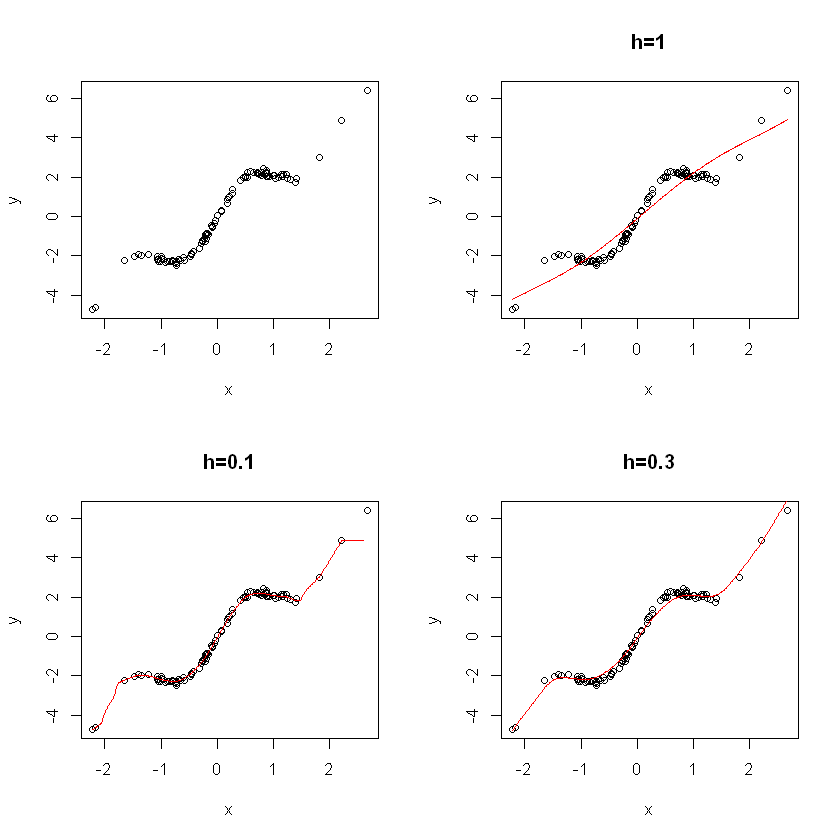

In [14]:
par(mfrow=c(2,2))
plot(x,y) 
h<-1;  plot(x,y,main=paste("h=", h, sep="")); lines(locpoly(x, y, kernel = "normal",bandwidth = h),col=2)
h<-0.1; plot(x,y,main=paste("h=", h, sep="")); lines(locpoly(x, y, kernel = "normal",bandwidth = h),col=2)
h<-0.3; plot(x,y,main=paste("h=", h, sep="")); lines(locpoly(x, y, kernel = "normal",bandwidth = h),col=2)

In [15]:
#Choose h or k by LOO#
n = length(x)
# n: sample size
h_seq = seq(from=0.05,to=1, by=0.01)
# smoothing bandwidths we are using
CV_err_h = rep(NA,length(h_seq))
for(j in 1:length(h_seq)){
h_using = h_seq[j]
CV_err = rep(NA, n)
for(i in 1:n){
X_val = x[i]
Y_val = y[i]
# validation set
X_tr = x[-i]
Y_tr = y[-i]
# training set
Y_val_predict = ksmooth(x=X_tr,y=Y_tr,kernel = "normal",bandwidth=h_using,
x.points = X_val)
CV_err[i] = (Y_val - Y_val_predict$y)^2
# we measure the error in terms of difference square
}
CV_err_h[j] = mean(CV_err)
}
CV_err_h

[1]         NA         NA         NA         NA         NA         NA
 [7]         NA         NA         NA         NA         NA         NA
[13]         NA         NA         NA         NA         NA         NA
[19]         NA         NA         NA         NA         NA         NA
[25]         NA         NA 0.05686643 0.05609919 0.05544802 0.05491025
[31] 0.05447828 0.05415262 0.05393106 0.05379649 0.05376126 0.05380790
[37] 0.05392684 0.05411868 0.05437828 0.05470713 0.05510619 0.05555182
[43] 0.05605377 0.05660533 0.05720581 0.05786271 0.05856680 0.05931393
[49] 0.06010991 0.06094894 0.06189127 0.06283175 0.06386389 0.06509141
[55] 0.06623001 0.06742373 0.06867307 0.07001459 0.07139698 0.07284683
[61] 0.07436038 0.07596319 0.07763720 0.07938205 0.08119620 0.08308198
[67] 0.08506349 0.08712737 0.08928012 0.09150346 0.09381709 0.09622419
[73] 0.09872116 0.10130918 0.10398290 0.10677283 0.10963356 0.11261092
[79] 0.11567389 0.11881209 0.12214566 0.12548721 0.12902907 0.13258313
[85] 0.13622541 0.13998317 0.14385742 0.14786228 0.15192876 0.15606851
[91] 0.16029142 0.16462182 0.16918513 0.17372654 0.17835206 0.18307081

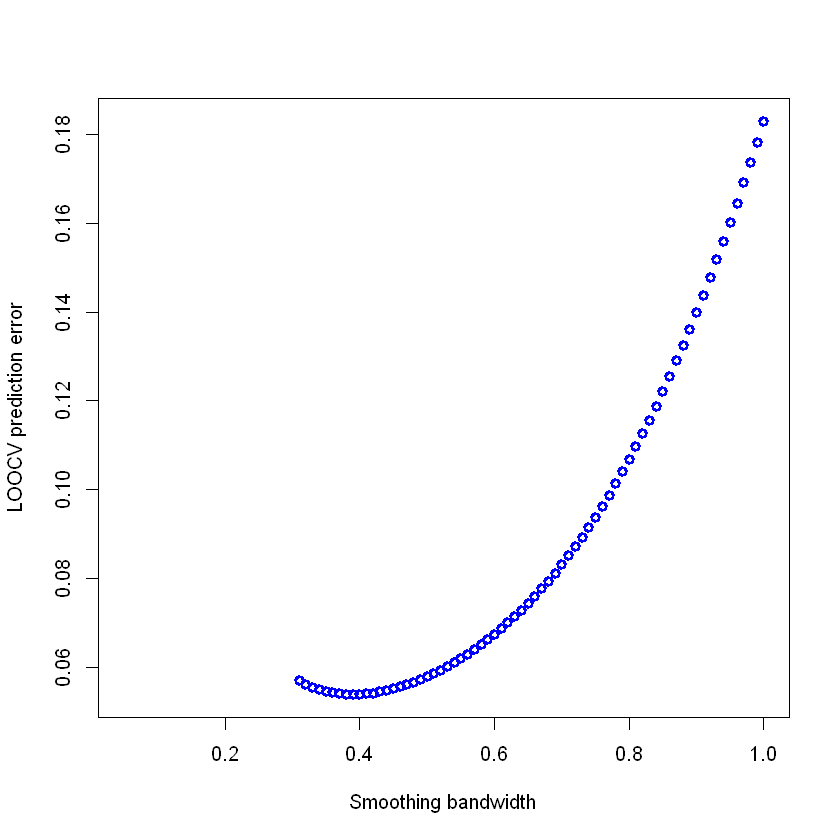

In [16]:
plot(x=h_seq, y=CV_err_h, type="b", lwd=3, col="blue", xlab="Smoothing bandwidth", ylab="LOOCV prediction error")

The LOOCV model give us the least error as 0.05376126 and the value of h was ranged from 0.05 to 1.0. The best value according to graph is 0.04. To be more precise and cross check the results, we will do k-fold cross validation.

In [17]:
h_seq[which(CV_err_h == min(CV_err_h))]

numeric(0)

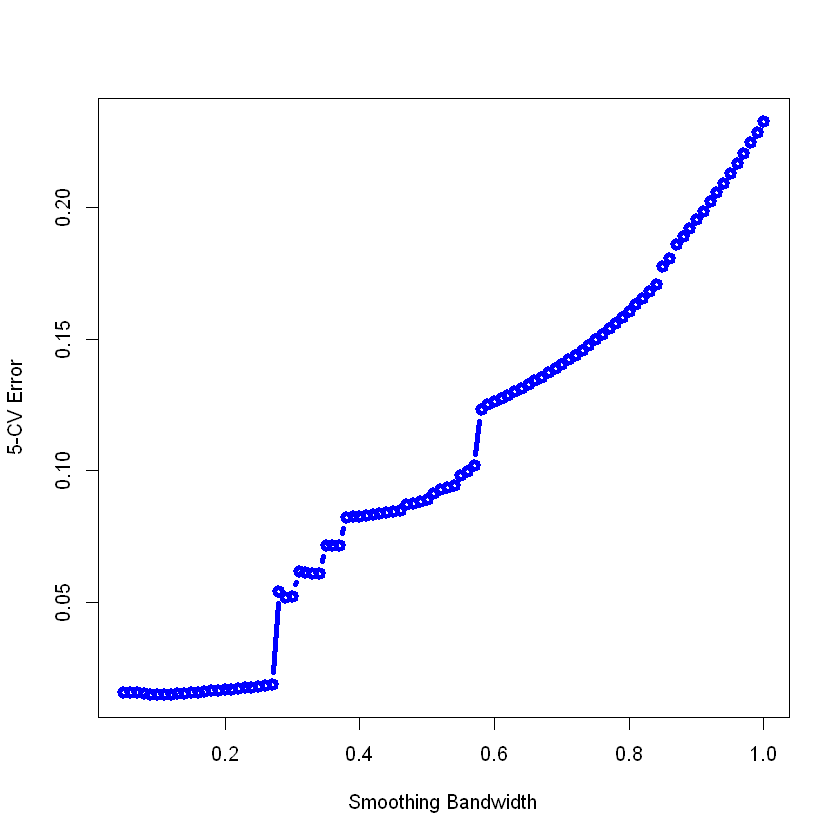

In [18]:
#5-fold Cross-validation#
#############5-fold Cross-validation############################################
set.seed(0)
n = length(x)
N_cv = 100
k = 5
cv_lab = sample(n,n,replace=F) %% k
## randomly split all the indices into k numbers
h_seq = seq(from=0.05,to=1, by=0.01)
CV_err_h = rep(0,length(h_seq))
for(i_tmp in 1:N_cv){
  CV_err_h_tmp = rep(0, length(h_seq))
  cv_lab = sample(n,n,replace=F) %% k
    for(i in 1:length(h_seq)){
    h0 = h_seq[i]
    CV_err =0
      for(i_cv in 1:k){
      w_val = which(cv_lab==(i_cv-1))
      X_tr = x[-w_val]
      Y_tr = y[-w_val]
      X_val = x[w_val]
      Y_val = y[w_val]
      kernel_reg = ksmooth(x = X_tr,y=Y_tr,kernel = "normal",bandwidth=h0,
      x.points=X_val)
      # WARNING! The ksmooth() function will order the x.points from
        # the smallest to the largest!
        CV_err = CV_err+mean((Y_val[order(X_val)]-kernel_reg$y)^2,na.rm=T)
        # na.rm = T: remove the case of 'NA'
        }
    CV_err_h_tmp[i] = CV_err/k
    }
  CV_err_h = CV_err_h+CV_err_h_tmp
  }
CV_err_h = CV_err_h/N_cv
plot(h_seq,CV_err_h, type="b", lwd=4, col="blue", xlab="Smoothing Bandwidth",
ylab="5-CV Error")

In [19]:
h_opt = h_seq[which(CV_err_h==min(CV_err_h))]
h_opt

end_time <- Sys.time()

end_time - start_time

[1] 0.1

Time difference of 10.33682 secs

The least error came with h as 0.1. Thus the best model should use the value of h as 0.1 in the kernel smoothing.